<a href="https://colab.research.google.com/github/AishaLichtner/projects-2019/blob/master/Blocktimes%2C_second_try_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q seaborn
!pip install -q pyyaml h5py 

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import tensorflow.compat.v1 as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,Conv1D,Conv3D, MaxPool2D , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge



from tensorflow.keras import optimizers as opt
import tensorflow.keras.backend as K
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import datetime
import statistics


#get last sunday of the month
import sys
import calendar

from tensorflow.keras import layers

print(tf.__version__)

import numpy as np     # matrix structures, linear algebra functions etc
from sklearn.linear_model import LinearRegression   # linear regression model
from sklearn.metrics import mean_squared_error, mean_absolute_error   # accuracy metrics

import io


1.15.0


# Load Data and filter

In [0]:
from google.colab import files
uploaded = files.upload()

In [0]:

from google.colab import drive

drive.mount('/content/drive')
path = "/content/drive/My Drive/data/blocks.csv"
#data = pd.read_csv(io.StringIO(uploaded["blocks.csv"].decode('utf-8')))
data= pd.read_csv(path,sep = ';', encoding="utf-8-sig")

airportStart="OSL"
airportDest="LGW"



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#data=pd.read_csv(path,header=0, delimiter='\t', engine='python' )


#show amount of rows that has invalid entires
data.isna().sum()

data.tail()

,Acreg,Version,Std UTC,Sta Utc,Flightcode,AOC,DP Iatacode,AR Iatacode,Rm Off Block Utc,Rm Takeoff Utc,TaxiOut,Rm Touchdown Utc,Rm On Block Utc,TaxiIn,BlkSched,ActualBlock
561264,YRBMI,737-800,30.08.2019 18:15,30.08.2019 21:55,DY4214,WET,PMI,ARN,30.08.2019 18:15,30.08.2019 18:25,10,30.08.2019 21:46,30.08.2019 21:51,5.0,220,216
561265,YRBMI,737-800,31.08.2019 06:15,31.08.2019 08:25,DY4487,WET,ARN,BUD,31.08.2019 06:15,31.08.2019 06:24,9,31.08.2019 08:24,31.08.2019 08:29,5.0,130,134
561266,YRBMI,737-800,31.08.2019 09:05,31.08.2019 11:15,DY4488,WET,BUD,ARN,31.08.2019 09:08,31.08.2019 09:28,20,31.08.2019 11:22,31.08.2019 11:28,6.0,130,140
561267,YRBMI,737-800,31.08.2019 12:05,31.08.2019 16:30,DY4223,WET,ARN,AGP,31.08.2019 12:21,31.08.2019 12:31,10,31.08.2019 16:21,31.08.2019 16:25,4.0,265,244
561268,YRBMI,737-800,31.08.2019 17:20,31.08.2019 21:30,DY4224,WET,AGP,ARN,31.08.2019 17:20,31.08.2019 17:27,7,31.08.2019 21:10,31.08.2019 21:22,12.0,250,242


filter by "WET" to exclude flights operated with other aircrafts

In [0]:
#exclude flights that are done with other planes
data= data.loc[data['AOC'] != "WET"]
data.tail()


,Acreg,Version,Std UTC,Sta Utc,Flightcode,AOC,DP Iatacode,AR Iatacode,Rm Off Block Utc,Rm Takeoff Utc,TaxiOut,Rm Touchdown Utc,Rm On Block Utc,TaxiIn,BlkSched,ActualBlock
559169,SERXZ,787-900,25.10.2019 12:50,26.10.2019 01:00,DY7109,NAS,BCN,LAX,25.10.2019 13:13,25.10.2019 13:41,28,26.10.2019 01:27,26.10.2019 01:35,8.0,730,742
559170,SERXZ,787-900,26.10.2019 03:00,26.10.2019 13:55,DY7110,NAS,LAX,BCN,26.10.2019 03:13,26.10.2019 03:35,22,26.10.2019 14:07,26.10.2019 14:12,5.0,655,659
559171,SERXZ,787-900,26.10.2019 17:25,27.10.2019 02:00,DY7195,NAS,BCN,EWR,26.10.2019 17:28,26.10.2019 17:52,24,27.10.2019 01:38,27.10.2019 02:12,34.0,515,524
559172,SERXZ,787-900,27.10.2019 03:59,27.10.2019 11:15,DY7196,NAS,EWR,BCN,27.10.2019 04:00,27.10.2019 04:22,22,27.10.2019 11:11,27.10.2019 11:16,5.0,436,436
559173,SERXZ,787-900,27.10.2019 17:05,28.10.2019 02:00,DY7025,NAS,BCN,JFK,27.10.2019 17:07,27.10.2019 17:31,24,28.10.2019 01:18,28.10.2019 01:31,13.0,535,504


In [0]:
#delete rows with invalid entries (nan-values)
data = data.dropna()

In [0]:
#selecting a specific flight, that is in this case Oslo Gatwick
data= data.loc[data['DP Iatacode'] == airportStart]
data =data.loc[data["AR Iatacode"] == airportDest]

get rid of information that does not influence the result

In [0]:
#deleting unnecessary data
flightBlock = data.copy()
flightBlock = flightBlock[["ActualBlock","Std UTC"]]


Split Date into time, weekday and season

In [0]:
#exclude date colum of flightBlock so we can split it in more information
date = flightBlock.pop("Std UTC")
date.tail()

543356    02.11.2018 17:10
543398    09.11.2018 17:10
543508    28.11.2018 06:20
543518    30.11.2018 12:20
558638    12.03.2019 06:15
Name: Std UTC, dtype: object

In [0]:

def lastSunday(year,month):
    if len(sys.argv) > 1:
        try:
            year = int(sys.argv[-1])
        except ValueError:
            pass
 
   
    last_sunday = max(week[-1] for week in calendar.monthcalendar(year, month))
    #print('{}-{}-{:2}'.format(year, calendar.month_abbr[month], last_sunday))
    return last_sunday


In [0]:
#returns 1 for winterseason and 0 for summer season
def getSeason(d):

    if (d.month<3 or d.month > 10):
        return 1;
    elif (d.month == 3 and d.day < lastSunday(d.year, d.month)):
        return 1;
    elif (d.month == 10 and d.day >= lastSunday(d.year, d.month)):
        return 1;
    else:
        return 0;
    

In [0]:
#create some more categories like time of the day, weekday and season
#date is the column of flightBlock 
dateForm=[datetime.datetime.strptime(s,'%d.%m.%Y %H:%M') for s in date]

times= [x.hour for x in dateForm]
weekdays =[x.weekday()+1 for x in dateForm]
months= [x.month for x in dateForm]
summer=[(getSeason(x)==0)*1 for x in dateForm]

#das habe ich getestet und das funktionniert

In [0]:
flightBlock['Time'] = times
flightBlock["Weekday"] = weekdays
flightBlock["Summer"] = summer
flightBlock["Month"] = months
flightBlock.tail()


,ActualBlock,Time,Weekday,Summer,Month
543356,123,17,5,0,11
543398,137,17,5,0,11
543508,129,6,3,0,11
543518,148,12,5,0,11
558638,141,6,2,0,3


# Find and delete outliers 

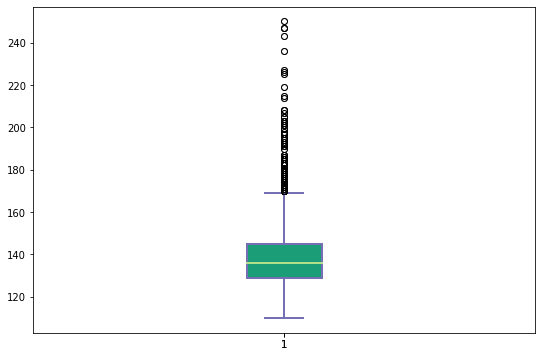

In [0]:
#Create boxplot of "ActualBlock" to see if there are outliers
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(flightBlock["ActualBlock"])

# Save the figure
fig.savefig('fig1.png', bbox_inches='tight')

## add patch_artist=True option to ax.boxplot() 
## to get fill color


bp = ax.boxplot(flightBlock["ActualBlock"], patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

In [0]:
#try to remove outliars by IQR-Score train_data_out will be the cleaned dataset
#dafuer muss man daten erst sortieren

#train_dataset=train_dataset.sort_values(["ActualBlock"], ascending=True)

oldSize=flightBlock.shape[0]


Q1 = flightBlock["ActualBlock"].quantile(0.25)
Q3 = flightBlock["ActualBlock"].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

#outliars beeing filtered
flightBlock_out = flightBlock[~((flightBlock["ActualBlock"] < (Q1 - 1.5 * IQR)) |(flightBlock["ActualBlock"] > (Q3 + 1.5 * IQR)))]
print("percentage of non-outlier flights:")
print(flightBlock_out.shape[0]/oldSize )
flightBlock_out.tail()


16.0
percentage of non-outlier flights:
0.9676932367149759


,ActualBlock,Time,Weekday,Summer,Month
543356,123,17,5,0,11
543398,137,17,5,0,11
543508,129,6,3,0,11
543518,148,12,5,0,11
558638,141,6,2,0,3


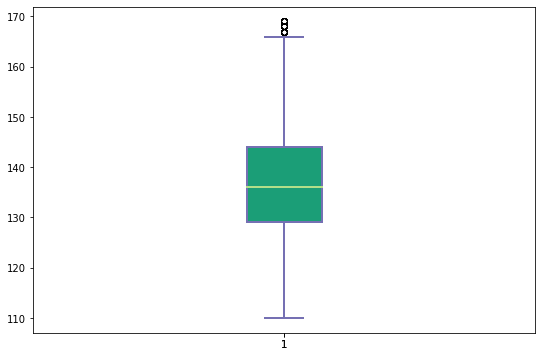

In [0]:
#Create boxplot of train_labels to see if outliars are gone
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(flightBlock_out["ActualBlock"])

# Save the figure
fig.savefig('fig2.png', bbox_inches='tight')

## add patch_artist=True option to ax.boxplot() 
## to get fill color


bp = ax.boxplot(flightBlock_out["ActualBlock"], patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

# Split dataset for training and testing datase/labels

In [0]:
#splitting data into trianing and test set still including the labels!
train_X = flightBlock_out.sample(frac=0.8,random_state=0)
test_X = flightBlock_out.drop(train_X.index)
train_labels = train_X.pop("ActualBlock")
test_labels =test_X.pop("ActualBlock")
test_labels.tail()

516379    122
526095    156
526252    145
526270    118
543350    138
Name: ActualBlock, dtype: int64

In [0]:
train_X

,Time,Weekday,Summer,Month
46071,5,1,1,6
57999,13,1,1,6
39709,8,7,1,9
107535,5,3,1,8
273817,5,4,1,4
...,...,...,...,...
300842,8,6,1,6
113147,11,1,1,6
26916,7,5,1,9
9420,5,3,1,6


# Scaling data 

In [0]:

transformer = RobustScaler().fit(train_X) 
RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)
train_X= transformer.transform(train_X)
test_X = transformer.transform(test_X)

#make it a pandas dataframe again
train_X = pd.DataFrame(train_X)
test_X=pd.DataFrame(test_X)

# Build some models

In [0]:
def build_model_simple():
    model = Sequential()
    model.add(Dense(12, activation='relu',kernel_initializer='normal', input_shape=[len(train_X.keys())]))
    model.add(Dense(10, activation='relu',kernel_initializer='normal'))
    model.add(Dense(1,kernel_initializer='normal'))
    model.compile(loss='mse',
                optimizer="adam",
                metrics=['mae', 'mse'])
    
    return model

In [0]:
def build_model_deeper():
    model = Sequential()
    model.add(Dense(5, activation='relu',kernel_initializer='normal', input_shape=[len(train_X.keys())]))
    model.add(Dense(12, activation='relu',kernel_initializer='normal'))
    model.add(Dense(10, activation='relu',kernel_initializer='normal'))
    model.add(Dense(5, activation='relu',kernel_initializer='normal'))
    model.add(Dense(1,kernel_initializer='normal'))
    model.compile(loss='mse',
                optimizer="adam",
                metrics=['mae', 'mse'])
    
    return model

In [0]:
def build_model_wider():
    model = Sequential()
    model.add(Dense(5, activation='relu',kernel_initializer='normal', input_shape=[len(train_X.keys())]))
    model.add(Dense(65, activation='relu',kernel_initializer='normal'))
    model.add(Dense(1,kernel_initializer='normal'))
    model.compile(loss='mse',
                optimizer="adam",
                metrics=['mae', 'mse'])
    
    return model

# Build costum loss function and build models with it

In [0]:
#try to build own loss function
# Define custom loss
def custom_loss():

    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true,y_pred):
           return K.cast(K.greater(K.abs(y_true-y_pred), 10),"float32")*K.cast(K.square((K.square(y_true-y_pred)))*1000,"float32" ) + K.cast(K.less_equal(K.abs(y_true-y_pred), 10),"float32")*K.cast(K.square(y_true-y_pred),"float32")*0.000000001
   
    # Return a function
    return loss


In [0]:
def custom_zwei():
     # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true,y_pred):
            d= y_true -y_pred
            late = K.cast( K.greater(d,10),"float") *K.cast(K.square(d-10),"float32")
            early =  K.cast( K.less(d,-10),"float") *K.cast((K.square(d+10)),"float32")
            onTime= K.cast(0,"float32")
            return late+early+onTime
    return loss


In [0]:
def build_model_simple_loss():
    model = Sequential()
    model.add(Dense(5, activation='relu',kernel_initializer='normal', input_shape=[len(train_X.keys())]))
    model.add(Dense(15, activation='relu',kernel_initializer='normal'))
    model.add(Dense(1,kernel_initializer='normal'))
    model.compile(loss=custom_zwei(),
                optimizer="adam",
                metrics=['mae', 'mse'])
    
    return model

In [0]:
def build_model_deeper_loss():
    model = Sequential()
    model.add(Dense(5, activation='relu',kernel_initializer='normal', input_shape=[len(train_X.keys())]))
    model.add(Dense(12, activation='relu',kernel_initializer='normal'))
    model.add(Dense(10, activation='relu',kernel_initializer='normal'))
    model.add(Dense(5, activation='relu',kernel_initializer='normal'))
    model.add(Dense(1,kernel_initializer='normal'))
    model.compile(loss=custom_zwei(),
                optimizer="adam",
                metrics=['mae', 'mse'])
    
    return model

In [0]:
def build_model_wider_loss():
    model = Sequential()
    model.add(Dense(5, activation='relu',kernel_initializer='normal', input_shape=[len(train_X.keys())]))
    model.add(Dense(65, activation='relu',kernel_initializer='normal'))
    model.add(Dense(1,kernel_initializer='normal'))
    model.compile(loss=custom_zwei(),
                optimizer="adam",
                metrics=['mae', 'mse'])
    
    return model

# Build some machine learning models 

In [0]:
#linear Regression
modelRE = LinearRegression()



In [0]:

alpha = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

ridge = Ridge()

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}

ridge_regressor = GridSearchCV(ridge, parameters,scoring='neg_mean_squared_error', cv=5)

In [0]:
from sklearn.linear_model import Lasso

lasso = Lasso()

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}

lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv = 5)



# Build an evaluation function that tests on time predictions

In [0]:

def testModel( predict, label,mod):
   # print("This is evaluation of model on NOT clean test data for model " + stringArq)
    
    showScatter(predict,label)
    showPredictions(predict, label)
    showError(predict, label)
    onTime(predict,label)
    notLate(predict,label)
    #testSameFlight(specificFlight,mod)
    showResults(predict,label)

In [0]:
#taking one specific flight to see if model gives same times
def testSameFlight(specFlight,model):
    a = specFlight.loc[specFlight["Time"] ==17 ]
    a= a.loc[a["Weekday"]==1]
    a= a.loc[a["Summer"]==0]
    print(a) 
    a.pop("ActualBlock")
    a=norm(a).values
    print("these are results for the same flight")
    print(model.predict(a).flatten())
 

In [0]:
def showScatter(predict, label):
    plt.scatter(label, predict)
    plt.xlabel('True Values [ActualBlock]')
    plt.ylabel('Predictions [ActualBlock]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([-300, 300], [-300, 300])
    plt.show()

In [0]:
def showError(predict, label):
    error =  label-predict
    plt.hist(error, bins = 25)

    plt.xlabel("Prediction Error [ActualBlock]")
    _ = plt.ylabel("Count")
    plt.show()

    print("this is the median of error, negative indicates too early arrival, positive late arrival")
    print(statistics.median(error))



In [0]:
def showPredictions(predict,label):
    tabel =pd.DataFrame()
    tabel["Test Predictions"] =predict
    tabel["Test ActualBlock"] =label
    print("These are the actual Block times and their predictions")
    tabel.tail()

In [0]:
#check how many of the flights are NOT on time (+- 10 minutes)

def onTime(predict, label):
    delay = (abs(label-predict) > 15)*1
    print("this is the percentage of flights that are not on time:")
    print(sum(delay) / len(delay))


In [0]:
#check how many of the flights are more than 10 minutes late

def notLate(predict, label):
    delay = ((label-predict) > 15)*1
    print("this is the percentage of flights that are more than 10 minutes late:")
    print(sum(delay) / len(delay))


In [0]:
#show actual function and approximated function
def showResults(predict, l):
    plt.figure()
    plt.xlabel('Samples')
    plt.ylabel('Blocktimes')
    plt.plot(predict,
           label='Prediction')
    plt.plot(l,
           label = 'Real Values')
    plt.ylim([100,200])
    plt.legend()

# Try to build deep believe network

In [0]:
!git clone -q https://github.com/albertbup/deep-belief-network/


fatal: destination path 'deep-belief-network' already exists and is not an empty directory.


In [0]:
!pip install -q /content/deep-belief-network

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from dbn.tensorflow import SupervisedDBNRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics.classification import accuracy_score

In [0]:
modelDeepBelieve = SupervisedDBNRegression(hidden_layers_structure = [300, 200,100,10],
learning_rate_rbm=0.05,
learning_rate=0.1,
n_epochs_rbm=5,
n_iter_backprop=100,
batch_size=16)

In [0]:

regressor = SupervisedDBNRegression(hidden_layers_structure=[100],
                                    learning_rate_rbm=0.01,
                                    learning_rate=0.01,
                                    n_epochs_rbm=5,
                                    n_iter_backprop=5,
                                    batch_size=64,
                                    activation_function='relu')

In [0]:
print("This is deep believe")

# Data scaling
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(train_X)

DBN =modelDeepBelieve.fit(X_train, train_labels)



This is deep believe
[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.061622
>> Epoch 2 finished 	RBM Reconstruction error 0.034999
>> Epoch 3 finished 	RBM Reconstruction error 0.039156
>> Epoch 4 finished 	RBM Reconstruction error 0.031534
>> Epoch 5 finished 	RBM Reconstruction error 0.049104
>> Epoch 1 finished 	RBM Reconstruction error 1.250876
>> Epoch 2 finished 	RBM Reconstruction error 0.420217
>> Epoch 3 finished 	RBM Reconstruction error 0.417209
>> Epoch 4 finished 	RBM Reconstruction error 0.379595
>> Epoch 5 finished 	RBM Reconstruction error 0.391869
>> Epoch 1 finished 	RBM Reconstruction error 0.810741
>> Epoch 2 finished 	RBM Reconstruction error 0.267482
>> Epoch 3 finished 	RBM Reconstruction error 0.129298
>> Epoch 4 finished 	RBM Reconstruction error 0.073875
>> Epoch 5 finished 	RBM Reconstruction error 0.031467
>> Epoch 1 finished 	RBM Reconstruction error 1.005863
>> Epoch 2 finished 	RBM Reconstruction error 0.830525
>> Epoch 3 finish

In [0]:
 reg=regressor.fit(X_train, train_labels)

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.347435
>> Epoch 2 finished 	RBM Reconstruction error 0.272640
>> Epoch 3 finished 	RBM Reconstruction error 0.253327
>> Epoch 4 finished 	RBM Reconstruction error 0.237951
>> Epoch 5 finished 	RBM Reconstruction error 0.220972
[END] Pre-training step
[START] Fine tuning step:
>> Epoch 0 finished 	ANN training loss 4629.950684
>> Epoch 1 finished 	ANN training loss 978.408142
>> Epoch 2 finished 	ANN training loss 289.587677
>> Epoch 3 finished 	ANN training loss 156.634293
>> Epoch 4 finished 	ANN training loss 130.737000
[END] Fine tuning step


In [0]:
X_test = min_max_scaler.transform(test_X)

print(X_test)



dbn_pred=DBN.predict(X_test).flatten()

dbn_pred

[[0.375      0.16666667 1.         0.45454545]
 [0.1875     1.         1.         0.63636364]
 [0.375      0.         1.         0.81818182]
 ...
 [0.75       0.         0.         0.        ]
 [0.75       0.5        0.         0.        ]
 [0.75       0.5        0.         0.90909091]]


array([130.51306, 130.51306, 130.51306, 130.51306, 130.51306, 130.51306,
       130.51306, 130.51306, 130.51306, 130.51306, 130.51306, 130.51306,
       130.51306, 130.51306, 130.51306, 130.51306, 130.51306, 130.51306,
       130.51306, 130.51306, 130.51306, 130.51306, 130.51306, 130.51306,
       130.51306, 130.51306, 130.51306, 130.51306, 130.51306, 130.51306,
       130.51306, 130.51306, 130.51306, 130.51306, 130.51306, 130.51306,
       130.51306, 130.51306, 130.51306, 130.51306, 130.51306, 130.51306,
       130.51306, 130.51306, 130.51306, 130.51306, 130.51306, 130.51306,
       130.51306, 130.51306, 130.51306, 130.51306, 130.51306, 130.51306,
       130.51306, 130.51306, 130.51306, 130.51306, 130.51306, 130.51306,
       130.51306, 130.51306, 130.51306, 130.51306, 130.51306, 130.51306,
       130.51306, 130.51306, 130.51306, 130.51306, 130.51306, 130.51306,
       130.51306, 130.51306, 130.51306, 130.51306, 130.51306, 130.51306,
       130.51306, 130.51306, 130.51306, 130.51306, 

# training phase

In [0]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement Early stopp muss unten als variable in callbacks eingefùegt werden
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [0]:
#dont know if that works, so I wont use it
def saveIt(model, path = "training_1/cp.ckpt"):
    #where the weights are stored
    checkpoint_path = path
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
    
    # Save the entire model to a HDF5 file.
    # The '.h5' extension indicates that the model shuold be saved to HDF5.
    model.save('my_model.h5') 

In [0]:
def trainMyModel(model,X,Y):
    history = model.fit(X.values, Y.values, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop,PrintDot()],batch_size=25)
    print("soweit so gut")
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    print(hist.keys())

    print("Training loss and mean square error")
    print(hist.tail())
    plot_history(history)

In [0]:

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,hist['val_mean_absolute_error'].max()+10])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,hist["mean_squared_error"].max()+10])
  plt.legend()
  plt.show()


In [0]:
#create the models
modSimple = build_model_simple()
modDeep = build_model_deeper()
modWider = build_model_wider()

modSimple_loss = build_model_simple_loss()
modDeep_loss = build_model_deeper_loss()
modWider_loss = build_model_wider_loss()

#train them

print("This is linear Regression")
modelRE.fit(train_X, train_labels)


This is linear Regression


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:

print("This is Ridge Regression")
ridge_regressor.fit(train_X, train_labels)


In [0]:
print("This is Lasso Regression")
lasso_regressor.fit(train_X, train_labels)


This is a simple Network

.......soweit so gut
Index(['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss',
       'val_mean_absolute_error', 'val_mean_squared_error', 'epoch'],
      dtype='object')
Training loss and mean square error
         loss  mean_absolute_error  ...  val_mean_squared_error  epoch
2  116.874158             8.689230  ...              131.590454      2
3  117.877422             8.758165  ...              131.367966      3
4  116.991697             8.716632  ...              132.547592      4
5  116.727563             8.682378  ...              132.068680      5
6  116.766595             8.692968  ...              131.477234      6

[5 rows x 7 columns]


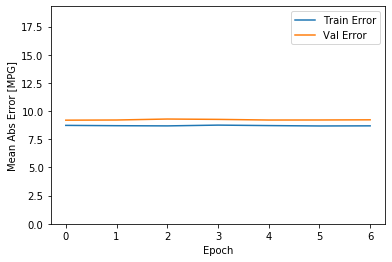

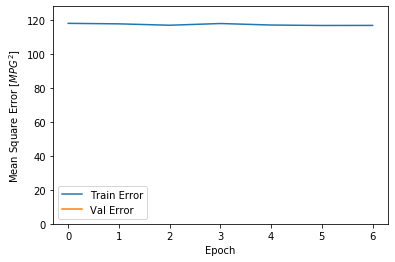

In [0]:
print("This is a simple Network")
trainMyModel(modSimple,train_X, train_labels)


This is a deeper Network

.......................................soweit so gut
Index(['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss',
       'val_mean_absolute_error', 'val_mean_squared_error', 'epoch'],
      dtype='object')
Training loss and mean square error
          loss  mean_absolute_error  ...  val_mean_squared_error  epoch
34  116.835660             8.700813  ...              131.744186     34
35  116.945326             8.705537  ...              132.665527     35
36  117.065489             8.687343  ...              131.565704     36
37  117.533437             8.692653  ...              131.581726     37
38  116.849838             8.707448  ...              131.719315     38

[5 rows x 7 columns]


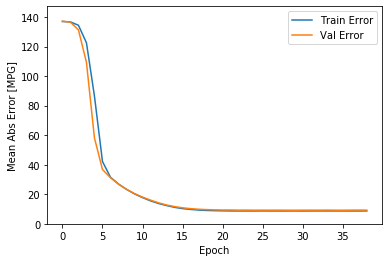

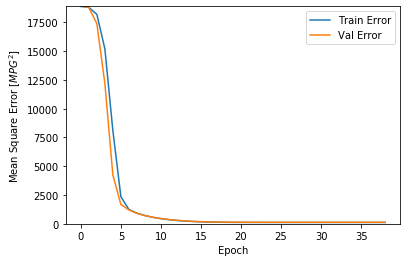

In [0]:
print("This is a deeper Network")
trainMyModel(modDeep,train_X, train_labels)


This is a wider Network

................................soweit so gut
Index(['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss',
       'val_mean_absolute_error', 'val_mean_squared_error', 'epoch'],
      dtype='object')
Training loss and mean square error
          loss  mean_absolute_error  ...  val_mean_squared_error  epoch
27  116.730981             8.711308  ...              131.661118     27
28  116.679949             8.697522  ...              131.801865     28
29  116.875787             8.698822  ...              131.844910     29
30  116.815204             8.693751  ...              132.139877     30
31  116.910420             8.691994  ...              131.825607     31

[5 rows x 7 columns]


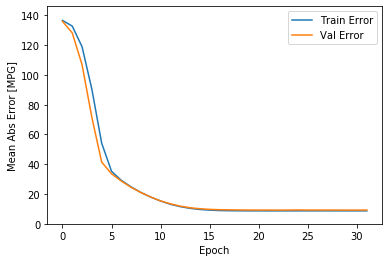

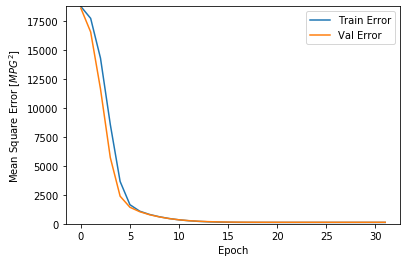

In [0]:
print("This is a wider Network")
trainMyModel(modWider,train_X, train_labels)


This is a simple Network with costumized loss

........................................................soweit so gut
Index(['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss',
       'val_mean_absolute_error', 'val_mean_squared_error', 'epoch'],
      dtype='object')
Training loss and mean square error
         loss  mean_absolute_error  ...  val_mean_squared_error  epoch
51  19.388286             8.925524  ...              132.343430     51
52  19.419382             8.948871  ...              132.309448     52
53  19.350186             8.919526  ...              131.506882     53
54  19.370654             8.929085  ...              132.401901     54
55  19.346346             8.885468  ...              132.451920     55

[5 rows x 7 columns]


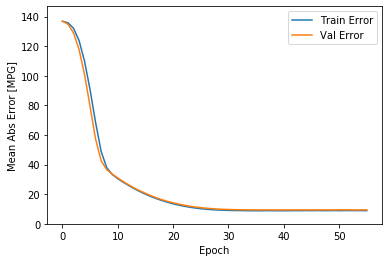

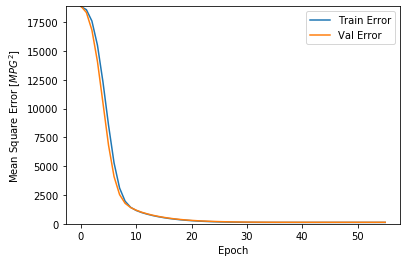

In [0]:
print("This is a simple Network with costumized loss")
trainMyModel(modSimple_loss,train_X, train_labels)


This is a deeper Network with costumized loss

......................................soweit so gut
Index(['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss',
       'val_mean_absolute_error', 'val_mean_squared_error', 'epoch'],
      dtype='object')
Training loss and mean square error
         loss  mean_absolute_error  ...  val_mean_squared_error  epoch
33  19.384545             8.953881  ...              131.637253     33
34  19.353096             8.930130  ...              133.650253     34
35  19.354874             8.944983  ...              131.306580     35
36  19.676867             8.881967  ...              132.718918     36
37  19.495671             8.944436  ...              132.619064     37

[5 rows x 7 columns]


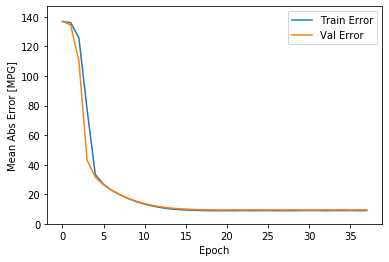

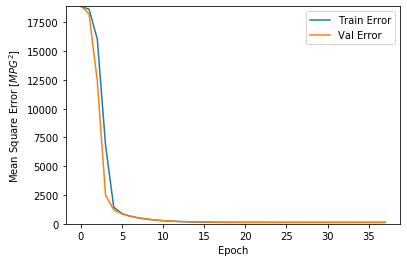

In [0]:
print("This is a deeper Network with costumized loss")
trainMyModel(modDeep_loss,train_X, train_labels)


This is a wider Network with costumized loss

...........................................soweit so gut
Index(['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss',
       'val_mean_absolute_error', 'val_mean_squared_error', 'epoch'],
      dtype='object')
Training loss and mean square error
         loss  mean_absolute_error  ...  val_mean_squared_error  epoch
38  19.409015             8.937688  ...              132.099762     38
39  19.305428             8.914288  ...              132.473358     39
40  19.373721             8.924406  ...              131.982437     40
41  19.335283             8.904551  ...              132.520569     41
42  19.372658             8.925243  ...              132.941193     42

[5 rows x 7 columns]


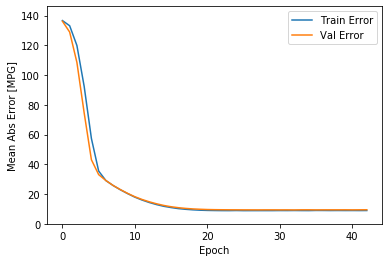

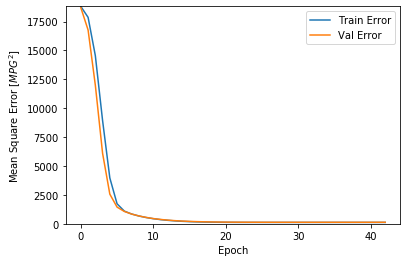

In [0]:
print("This is a wider Network with costumized loss")
trainMyModel(modWider_loss,train_X, train_labels)

#  Evaluate models on test data

This is linear Regression


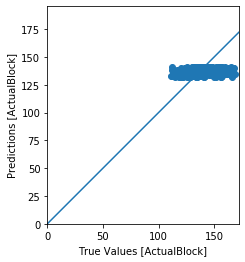

These are the actual Block times and their predictions


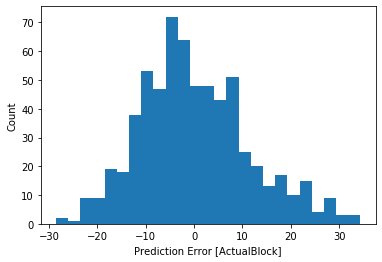

this is the median of error, negative indicates too early arrival, positive late arrival
-1.1870363941418702
this is the percentage of flights that are not on time:
0.18408736349453977
this is the percentage of flights that are more than 10 minutes late:
0.11076443057722309


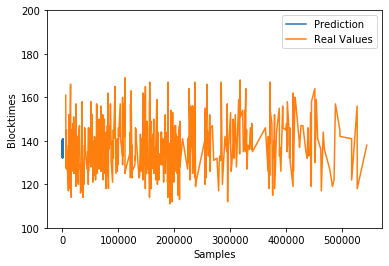

In [0]:

print("This is linear Regression")
testModel(modelRE.predict(test_X), test_labels ,modelRE)


In [0]:
print("This is Ridge Regression")
testModel(ridge_regressor.predict(test_X).flatten(),test_labels,ridge_regressor)


In [0]:
print("This is Lasso Regression")
testModel(lasso_regressor.predict(test_X).flatten(),test_labels,lasso_regressor)


In [0]:
print("This is a simple Network")
testModel(modSimple.predict(test_X).flatten(),test_labels,modSimple)


In [0]:
print("This is a deeper Network")
testModel(modDeep.predict(test_X).flatten(),test_labels,modDeep)


In [0]:
print("This is a wider Network")
testModel(modWider.predict(test_X).flatten(),test_labels,modWider)


In [0]:
print("This is a simple Network with costumized loss")
testModel(modSimple.predict(test_X).flatten(),test_labels,modSimple)


In [0]:
print("This is a deeper Network with costumized loss")
testModel(modDeep_loss.predict(test_X).flatten(),test_labels,modDeep_loss)
print(modDeep_loss.predict(test_X).flatten())

In [0]:
print("This is a wider Network with costumized loss")
testModel(modWider_loss.predict(test_X).flatten(),test_labels,modWider_loss)